In [1]:
pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import models, layers

In [3]:
# Memuat dataset

url = 'https://raw.githubusercontent.com/A-Feed/Data-Cleaning/main/Dataset/data_label_optimal.csv'
data = pd.read_csv(url)

In [4]:
# Encoding Type Ikan dan Optimal

label_encoder_type = LabelEncoder()
data['type'] = label_encoder_type.fit_transform(data['type'])

label_encoder_optimal = LabelEncoder()
data['label'] = label_encoder_optimal.fit_transform(data['label'])

In [5]:
# Split Features dan Target

X = data[['ph', 'temp', 'type']]
Y = data['label']

In [6]:
# Split dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# Scale features

scaler_feature = StandardScaler()
X_train = scaler_feature.fit_transform(X_train)
X_test = scaler_feature.fit_transform(X_test)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
181/181 [==============================] - 2s 4ms/step - loss: 0.8188 - accuracy: 0.5048 - val_loss: 0.6426 - val_accuracy: 0.7497
Epoch 2/30
181/181 [==============================] - 1s 3ms/step - loss: 0.6344 - accuracy: 0.7317 - val_loss: 0.5876 - val_accuracy: 0.7497
Epoch 3/30
181/181 [==============================] - 1s 3ms/step - loss: 0.5647 - accuracy: 0.7590 - val_loss: 0.5171 - val_accuracy: 0.7497
Epoch 4/30
181/181 [==============================] - 1s 3ms/step - loss: 0.5155 - accuracy: 0.7628 - val_loss: 0.4677 - val_accuracy: 0.7497
Epoch 5/30
181/181 [==============================] - 1s 5ms/step - loss: 0.4886 - accuracy: 0.7628 - val_loss: 0.4288 - val_accuracy: 0.7497
Epoch 6/30
181/181 [==============================] - 1s 5ms/step - loss: 0.4635 - accuracy: 0.7628 - val_loss: 0.3947 - val_accuracy: 0.7497
Epoch 7/30
181/181 [==============================] - 1s 5ms/step - loss: 0.4349 - accuracy: 0.7628 - val_loss: 0.3605 - val_accuracy: 0.7497
Epoch 

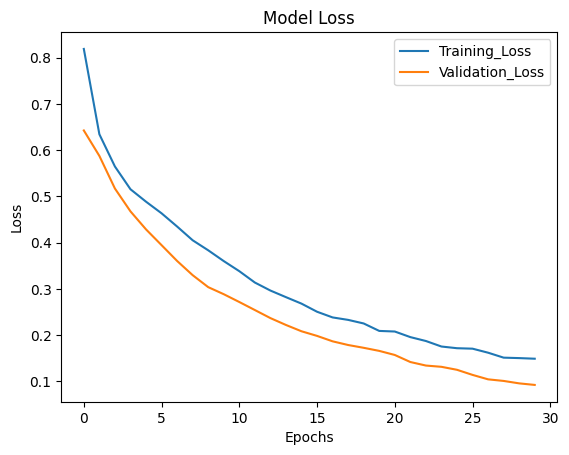

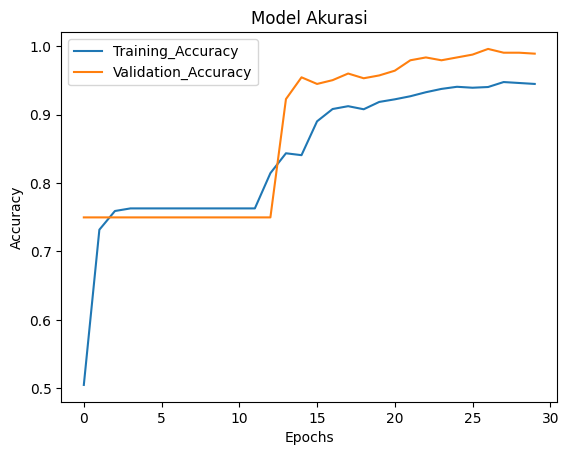

In [11]:
# Grafik Loss

plt.plot(history.history['loss'], label='Training_Loss')
plt.plot(history.history['val_loss'], label='Validation_Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Grafik Akurasi
plt.plot(history.history['accuracy'], label='Training_Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation_Accuracy')
plt.title('Model Akurasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Evaluasi Model

loss, accuracy = model.evaluate(X_test, Y_test)
print(f'test accuracy : {accuracy*100:.2f}%')

29/29 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9923
test accuracy : 99.23%


In [13]:
# Menyimpan Model

model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
#load model

loaded_model = tf.keras.models.load_model('model.h5')

In [15]:
#membuat objek konverter TFLite

tflite_converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

In [16]:
#proses konversi

converted_tf_lite_model = tflite_converter.convert()

In [17]:
# Menyimpan Model

output_file = 'model.tflite'
with open(output_file, 'wb') as file_writer:
  file_writer.write(converted_tf_lite_model)

print(f"Model telah dikonversi ke format TFLite dan disimpan sebagai '(output_file)'.")

Model telah dikonversi ke format TFLite dan disimpan sebagai '(output_file)'.


In [18]:
model_path = 'model.tflite'

In [22]:
def test_tflite_model(model_path, scaler):
    try:
        # Load TFLite Model
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        # Get input and output tensors
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Test input data
        test_ph = 7.8
        test_temp = 27.0
        test_type = 'ikan nila'

        # Convert type to numerical
        type_mapping = {
            'ikan lele': 1,
            'ikan nila': 2,
            'ikan gurame': 3
        }
        test_type_numeric = type_mapping[test_type]

        # Prepare input data in the required shape and type
        input_data = np.array([[test_ph, test_temp, test_type_numeric]], dtype=np.float32)

        # Normalize input data using the provided scaler
        input_data_scaled = scaler.transform(input_data)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data_scaled)

        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Threshold for classification
        threshold = 0.5
        if output_data[0][0] > threshold:
            prediction = 'optimal'
        else:
            prediction = 'kurang optimal'

        return prediction

    except Exception as e:
        print(f"Error testing TFLite model: {str(e)}")
        return None

# Load scaler_feature yang digunakan pada saat training
#scaler_feature = StandardScaler()
#X_train_scaled = scaler_feature.fit_transform(X_train)  # Skala fitur pada data training

# Uji model TFLite dengan fungsi yang diperbarui
output_label = test_tflite_model(model_path, scaler_feature)

if output_label is not None:
    print("Prediksi:", output_label)

Prediksi: optimal


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
